<p style="font-size:32px; font-weight: bolder; text-align: center"> Ring Polymer Molecular Dynamics </p>

<p style="font-size:16px; font-weight: bold; text-align: center"> Author: Venkat Kapil [vk380@cam.ac.uk]</p>

### 

This notebook provides a hands-on counterpart to the "Ring polymer molecular dynamics" lecture for the MOOC "Path Integrals in Atomistic Modeling". 

The different sections in this notebook match the parts this lecture is divided into:

1. RPMD 2
2. RPMD 3 
3. RPMD 4 

<p style="color:blue; font-weight:bold"> Questions in blue invite you to reflect on the results you are obtaining. If you are doing these notebooks as part of a course, there might be questions to answer relative to those parts. </p>

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
pimdmooc.add_ipi_paths()

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

# EXERCISE 1: Quantum time correlation functions

We consider a (classical) harmonic oscillator with frequency $\omega$ and unit mass, in the constant-temperature ensemble at inverse temperature $\beta$. 

## Standard quantum time correlation function

The standard quantum time auto-correlation function of the position operator is given as

$C^{\text{std}}_{\hat{q}\hat{q}}(t) = Z^{-1} \sum_{i} e^{-\beta E_{i}} \sum_{j} e^{ -i(E_{i} - E_{j}) t / \hbar} ~ <i| \hat{q} | j> ~ < j | \hat{q} | i >$

where 
- $E_i$ is the energy of the i-th eigenstate of the system
- $<i|\hat{q}|j>$ is the ij-th matrix element of the position operator
- $Z$ is the quantum canonical partition function

Let us define functions for some of these for a simple harmonic oscillator [in reduced  units]!

In [3]:
m = 1
hbar = 1
beta = 1

In [4]:
def Ei(i, omega=1, return_zero=False):
    """
    Return the energy of the i-th eigen state of the simple harmonic oscillator.
    """
    
    if return_zero:
        return (i + 1/2) * hbar * omega 
    else:
        return (i) * hbar * omega 
    
    
def qij(i, j, omega=1):
    """
    Return the expection value of <i| q |j> where q is the position operator and 
    |i>, |j> correspond to the i-th and j-th eigenstate of the sinple harmonic oscillator.
    Invoking ladder operators, the position  operator is written as
    
    q = \sqrt[ h / (2 m w) ] (a + a†) 
    
    Thus, 
    
    qij = \sqrt[ h / (2 m w) ] (<i | a | j> + <i | a† | j>)
    
    with
    
    <i | a | j> = sqrt[j] delta(i, j-1)
    <i | a† | j> = sqrt[j+1] delta(i, j+1)
    
    """
    
    if i == j - 1:
        return np.sqrt(hbar / (2 * m * omega)) * np.sqrt(j) 
    elif i == j + 1:
        return np.sqrt(hbar / (2 * m * omega)) * np.sqrt(j + 1) 
    else: 
        return 0

<p style="color:blue; font-weight:bold"> You may have learnt in your undergrad QM course that the position operator can be expressed in terms of ladder operators. These ladder operators essentially "upgrade" or "downgrade" the eigenstate by one, i.e. $\left(|i\rangle \to |i \pm 1\rangle\right)$.  By virtue of this property, can you verify which matrix elements of the position operator will be zero? </p>.

In [25]:
# Try here. 
# Hint: estimate  qij(i, j, omega=1) for i = j, i = j +/- 1, i = j +/- 2 , ....., and look for a pattern :) 

Let us now define a function that evaluates the standard time correlation function by summping up matrix elements up to the i-th eigenstate.

In [18]:
def Cqq_std(t, omega=1, i_max=100):
    """
    Calculates the standard quantum time correlation function of a simple harmonic oscillator 
    by considering the first i_max eigenstates.
    """
    
    rc = 0
    rz = 0
        
    for i in range(i_max + 1):
        
        sumj = 0
        for j in range(0, i + 2): 
            sumj += np.exp(-1j * (Ei(i, omega) - Ei(j, omega)) * t / hbar) * qij(i,j) * qij(j,i)
            
        rc += sumj * np.exp (-beta * Ei(i, omega))
        rz += np.exp (-beta * Ei(i, omega))

    
    if i_max > 0:
        return rc / rz
    else:
        return t * 0

## Let us calculate the standard time correlation function!

Here is a small snippet that plots the real and imaginary parts of the standard time correlation function for $t \in [0, 10]$ with an overconservative value of the highest eigenstate. 

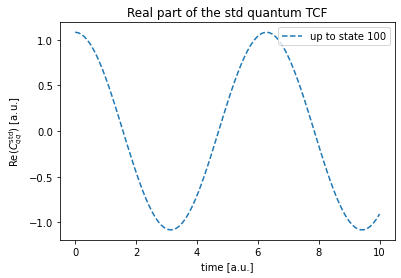

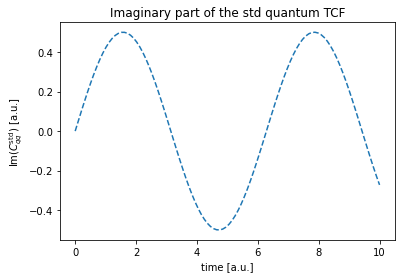

In [30]:
t = np.linspace(0,10, 100)
i_max = 100

plt.title('Real part of the std quantum TCF')
plt.xlabel('time [a.u.]')
plt.ylabel('Re($C^{\mathrm{std}}_{qq}$) [a.u.]')
plt.plot(t, np.real(Cqq_std(t, 1, i_max)), label= 'up to state ' +  str(i_max), ls='--')
plt.legend()
plt.show()


plt.title('Imaginary part of the std quantum TCF')
plt.xlabel('time [a.u.]')
plt.ylabel('Im($C^{\mathrm{std}}_{qq}$) [a.u.]')
plt.plot(t, np.imag(Cqq_std(t, 1, i_max)), label= 'up to state ' +  str(i_max), ls='--')
plt.show()

<p style="color:blue; font-weight:bold"> Can you check the number of eigenstates needed to "visibly" converge the real and imaginary terms? Plot the converged real and imaginary parts for $t \in [-100, 100]$. Can you also check if the real and imaginary parts of the standard quantum TCF are odd or even functions? </p>

In [31]:
# try here. 
# Hint: extend the range of time and plot the real and imaginary parts of the standard TCF as a function of the number of eigenstates.

## Kubo-transformed time correlation function

The Kubo-transformed quantum time auto-correlation function of the position operator is given as

$C^{\text{kubo}}_{\hat{q}\hat{q}}(t) = (Z \beta)^{-1} \int_{0}^{\beta} d\lambda  \sum_{i} e^{-(\beta - \lambda) E_i} 
   (\sum_{j} exp^{-\lambda E_j} \exp^{ -i(E_i - E_j) t / \hbar} ~ <i| \hat{q} | j> ~ < j | \hat{q} | i >)$

which can also be written as

$C^{\text{kubo}}_{\hat{q}\hat{q}}(t) = Z^{-1} \sum_{i} e^{-\beta E_i} \sum_{j} e^{ -i(E_i - E_j) t / \hbar}  ~ <i| \hat{q} | j> ~ < j | \hat{q} | i > 
              \frac{\int_{0}^{\beta} d\lambda  e^{-\lambda (E_j-E_i)}}{\int_{0}^{\beta} d\lambda} $



Let us reuse the functions to study the convergence of the Kubo-transformated position auto-correlation function. 
Note that we will need to converge w.r.t the granuality of the integration over imaginary time (beta) and over the maximum occupied eigenstate. To begin, we can assume the two to be independent parameters.

In [32]:
def Cqq_kubo(t, omega=1, i_max=100, lgrid=1000):
    """
    Calculates the standard quantum time correlation function of a simple harmonic oscillator 
    by considering the first i_max eigenstates.
    """
    
    rcqq = 0
    rz = 0
    
    lgrid = np.linspace(0, beta, lgrid)
    
    for i in range(i_max + 1):
                
        for j in range(i + 2): 
            
            lterm = np.sum(np.exp(-lgrid * (Ei(j) - Ei(i)))) * (lgrid[1] - lgrid[0]) / beta
            rcqq += lterm * np.exp (-(beta) * Ei(i)) * np.exp(-1j * (Ei(i) - Ei(j)) * t / hbar) * qij(i,j) * qij(j,i)
            
        rz += np.exp (-beta * Ei(i))
        
    if i_max > 0:
        return rcqq / rz
    else:
        return t * 0

This snippet that plots the real and imaginary parts of the kubo-transformed time correlation function for $t \in [0, 10]$ with an overconservative values of the highest eigenstate and the integration grid over $\lambda$.

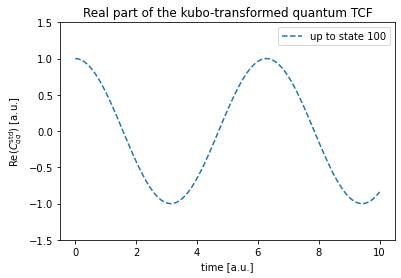

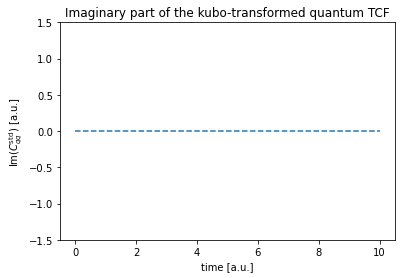

In [37]:
t = np.linspace(0,10, 100)
i_max = 100

plt.title('Real part of the kubo-transformed quantum TCF')
plt.xlabel('time [a.u.]')
plt.ylabel('Re($C^{\mathrm{std}}_{qq}$) [a.u.]')
plt.plot(t, np.real(Cqq_kubo(t, 1, i_max)), label= 'up to state ' +  str(i_max), ls='--')
plt.legend()
plt.ylim(-1.5,1.5)
plt.show()


plt.title('Imaginary part of the kubo-transformed quantum TCF')
plt.xlabel('time [a.u.]')
plt.ylabel('Im($C^{\mathrm{std}}_{qq}$) [a.u.]')
plt.plot(t, np.imag(Cqq_kubo(t, 1, i_max)), label= 'up to state ' +  str(i_max), ls='--')
plt.ylim(-1.5,1.5)
plt.show()


<p style="color:blue; font-weight:bold"> Can you check the number of eigenstates needed to "visibly" converge the real and imaginary terms? Can you check the granuality of the lambda grid needed to "visibly" converge the real and imaginary terms? Plot the converged real and imaginary parts for $t \in [-100, 100]$. Can you also check if the real and imaginary parts of the kubo-transformed quantum TCF are odd or even functions? </p>

In [116]:
# try here. 

## Detailed balance relation

As you can see for $\beta$ >> $\hbar \omega$ the standard and the kubo-transformed quantum position autocorrelation functions deviate from one another. Let us now verify whether their Fourier transforms are related by the harmonic detail balance correction factor. To ensure that we can verify this relation numerically, we multiply the position autocorrelation by a soft damping function. This ensures that our signal goes to zero and thus its integral can numerically computed by quadrature. In practice this prevents spectral leakage. 

Here is a snippet that computes the damping function and plots it. 

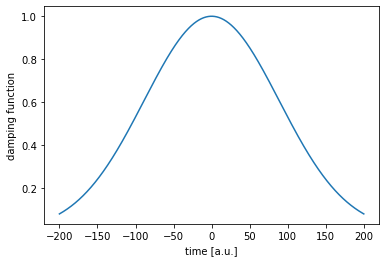

In [141]:
t = np.linspace(-200,200, 10000)

def fdamp(t):
    """
    An even dampling function
    """
    
    return np.exp(-(t / 40 / np.pi)**2)

plt.xlabel('time [a.u.]')
plt.ylabel('damping function')
plt.plot(t, fdamp(t), label='')
plt.show()

And here is a snippet that does basic fourier analysis of a sum of waves of randomly sampled frequencies.

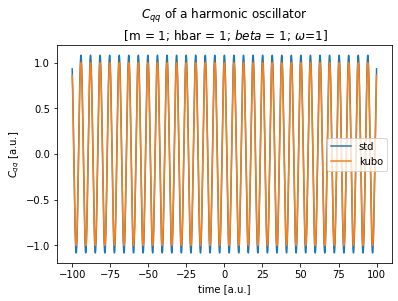

In [13]:
t = np.linspace(-100,100, 10000)
plt.title('$C_{qq}$ of a harmonic oscillator\n [m = 1; hbar = 1; $beta$ = 1; $\omega$=1]')
plt.xlabel('time [a.u.]')
plt.ylabel('$C_{qq}$ [a.u.]')
plt.plot(t, np.real(Cqq_std(t)), label='std')
plt.plot(t, np.real(Cqq_kubo(t)), label='kubo')
plt.legend()
plt.show()


In [ ]:
_nw = 5
# samples frequencies in the range 0, 1
ws = np.random.rand(_nw)

This is a sum of waves of these frequencies:  [0.86263942 0.06654883 0.78212245 0.07458613 0.42023104]


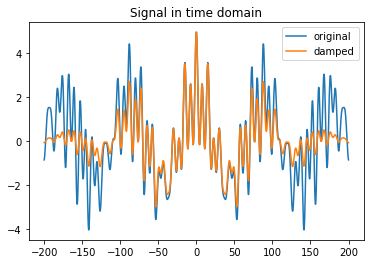

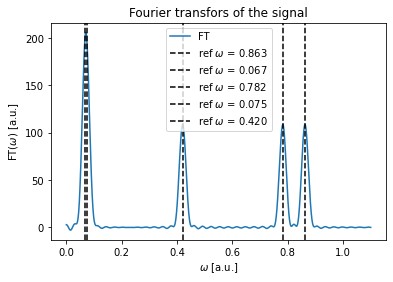

In [143]:
t = np.linspace(-200,200, 1000)

print ("This is a sum of waves of these frequencies: ", ws)

def wave(t, ws):
    """
    A sum of cosine waves.
    """
    return np.sum(np.cos(np.outer(ws,t)), axis=0)

signal = wave(t, ws)
plt.title('Signal in time domain')
plt.plot(t, signal, label='original')
signal = wave(t, ws) * fdamp(t) 
plt.plot(t, signal, label='damped')
plt.legend()
plt.show()


dt = t[1] - t[0]
w = np.linspace(0, 1.1, 10000)
ft = np.zeros(w.shape)
for i in range(len(w)):
    ft[i] = np.real(np.sum(dt * np.exp(-1j * w[i] * t) * signal))
    
plt.title('Fourier transfors of the signal')
plt.plot(w, ft, label='FT')
for tmpw in ws:
    plt.axvline(x=tmpw, color='k', label=r'ref $\omega$ = %5.3f' % (tmpw), ls='--')

plt.xlabel('$\omega$ [a.u.]')
plt.ylabel('FT($\omega)$ [a.u.]')
plt.legend()
plt.show()

<p style="color:blue; font-weight:bold"> Let's numerically calculate the left and right hand sides of Eq. 4.11, i.e. compute the Fourier transforms of the standard and Kubo transformed autocorrelation functions and see if their ratio is given by Eq. 4.12. How does this relation depend on the damping function used? </p>

In [144]:
# try here. 
# Hint: Compute the FT of the std and kubo-transformed TCFs and compute their ratio.

# EXERCISE 2: Properties of classical dynamics

A harmonic oscillator (in reduced units) samples the following canonical distribution

$ P(p) \propto e^{-\beta p^2 / 2}$

$ P(q) \propto e^{-\beta q^2 / 2}$ 

Let us sample initial configurations from these distibutions. 

In [145]:
n_trajs = 10

p0s = []
q0s = []

for i in range(n_trajs):
    p0s.append(np.random.normal())
    q0s.append(np.random.normal())

Let's also define the force on a harmonic oscillator (needed to perform molecular dynamics)

In [147]:
def f(q):
    """
    The force acting on a simple harmonic oscillator [in reduced units]
    """
    return -q

Here is a simple velocity verlet scheme to perform molecular dynamics. The trajectories are saved in the dictionary `traj_ens`.

In [148]:
traj_ens = {}

for j, p0, q0 in zip(range(n_trajs), p0s, q0s):

    p = p0
    q = q0
    dt = 0.01
    tmax = 100
    steps = int(tmax / dt)
    
    traj_ens[j] = {}

    plist = []
    qlist = []
    flist = []
    
    for i in range(steps):

        p = p + (f(q)) * dt / 2
        q = q + p * dt
        p = p + (f(q)) * dt / 2

        plist.append(p)
        qlist.append(q)
        flist.append(f(q))


    traj_ens[j]['plist'] = plist
    traj_ens[j]['qlist'] = qlist
    traj_ens[j]['flist'] = flist
    

## Conservation of phase-space volume

We note that the velocity-Verlet scheme can be summarized as follows:

$q(t + dt) = q(t) + p(t)~dt  + \frac{1}{2}~f(q(t))~dt^2$

$p(t + dt) = p(t) + \frac{1}{2} \left(f(q(t)) + f(q(t + dt))\right)~dt$

The Jacobian of the transformation of the phase-space vector from time $t$ to $t + dt$
can be calculated as

$J = \begin{vmatrix}
\frac{\partial p(t + dt)}{\partial p(t)} & \frac{\partial p(t + dt)}{\partial q(t)} \\
\frac{\partial q(t + dt)}{\partial p(t)} & \frac{\partial q(t + dt)}{\partial q(t)}
\end{vmatrix} = \begin{vmatrix}
1 & \frac{1}{2} f'(q(t))~dt \\
dt & 1 + \frac{1}{2} f'(q(t))~dt^2
\end{vmatrix}$

Clearly, the determinant is 1, hence the dynamics conserves the differential volume of the phase-space vector. 

We can, however, verify the conservation of volume numerically in the following way. Let us visualize the positions as a function of time for the sampled trajectories

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


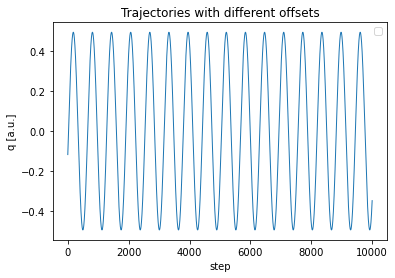

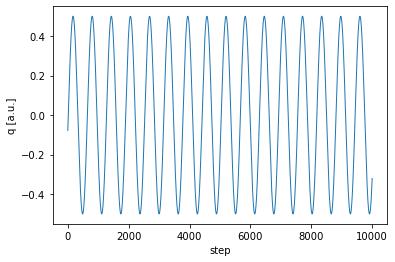

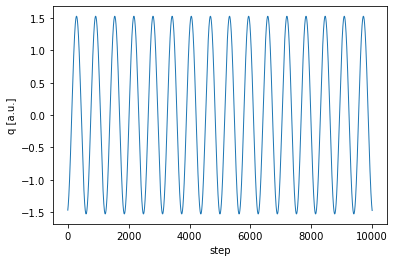

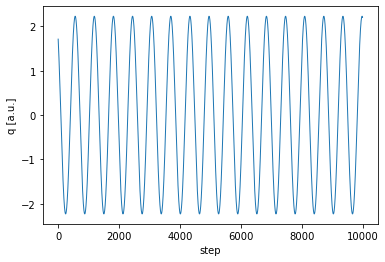

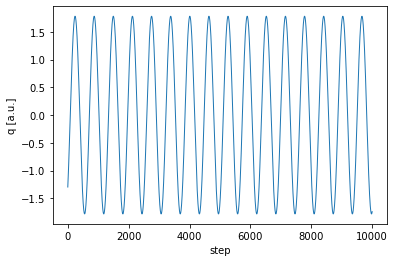

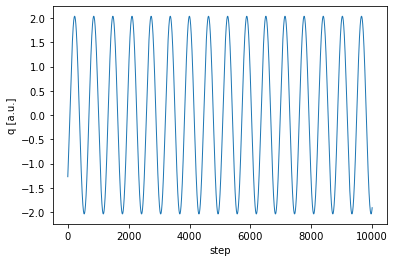

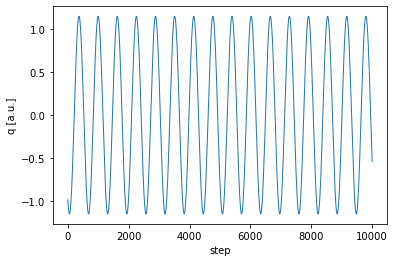

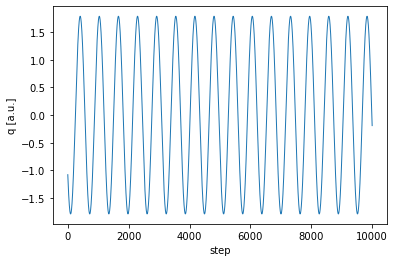

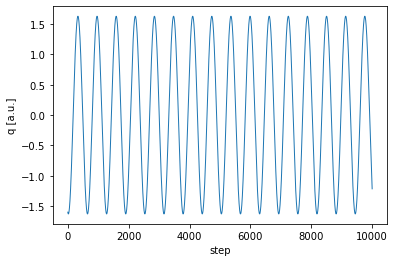

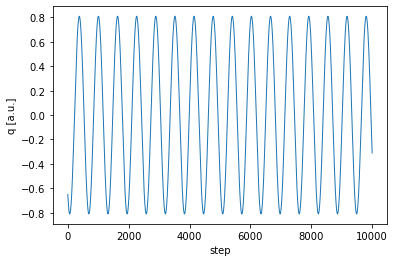

In [154]:
plt.title('Trajectories with different offsets')
plt.legend()
for i in range(n_trajs):
    qlist = traj_ens[i]['qlist']
    dq = np.asarray(qlist)
    plt.plot(range(len(qlist)), dq, lw=1.0, ls='-', label='traj ' + str(i))
    plt.xlabel('step')
    plt.ylabel('q [a.u.]')
    plt.show()




Let us also visualize the phase-space vector a function of time

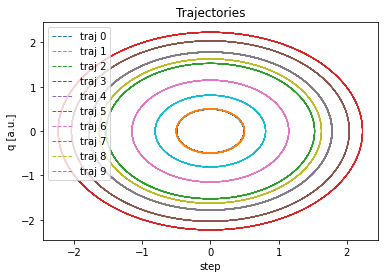

In [155]:
plt.title('Trajectories')

for i in range(n_trajs):
    qlist = traj_ens[i]['qlist']
    plist = traj_ens[i]['plist']
    dq = np.asarray(qlist)
    plt.plot(qlist, plist, lw=1.0, ls='--', label='traj ' + str(i))
    plt.xlabel('step')
    plt.ylabel('q [a.u.]')

plt.legend()

Considering the phase-space vector to be a parametric curve (with respect to time), conservation of the phase-space volume can be numerically checked by calculating the arc length $\delta p^2 + \delta q^2$. Note that the change in position and momentum can be calculates using 

$\delta q(t) = q(t + dt) - q(t) = p(t)~dt  + \frac{1}{2}~f(q(t))~dt^2$

$\delta p(t) = p(t + dt) - p(t) = \frac{1}{2} \left(f(q(t)) + f(q(t + dt))\right)~dt$

Can you verify if the arc length of the phase space vector is conserved during the dynamics?

<p style="color:blue; font-weight:bold"> Verify if the arc length of the phase space vector is conserved during the dynamics by plotting $\delta q(t) / dt$, $\delta q(t)  / dt$, and $\sqrt{\delta p^2(t) + \delta q^2(t)} / dt$ ? Is the arc length per timestep exactly zero? How does it depend on the timestep? </p>

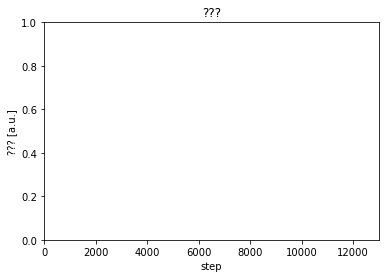

In [163]:
plt.title('???')

for i in range(n_trajs):
    qlist = traj_ens[i]['qlist']
    plist = traj_ens[i]['plist']
    flist = traj_ens[i]['flist']
        
    p = np.asarray(plist)
    f = np.asarray(flist)
    q = np.asarray(qlist)
    
    # compute here
    # plot here
    
    plt.xlabel('step')
    plt.ylabel('??? [a.u.]')
    plt.xlim(0, int(len(qlist) * 1.3))


plt.show()

## Conservation of the Boltzmann distribution

Here is a function that calculates the boltzmann weight associates with a point in phase space for a harmonic oscillator.

In [165]:
def boltzweight(p, q, beta):
    """
    Returns the classical botzmann weight for a microstate defined by p, q
    """
    
    return np.exp(-beta * (ps**2 / 2 + qs**2 / 2)) 

<p style="color:blue; font-weight:bold"> Can you use this function to verify if the Boltzmann weight is conserved along a trajectory? You can plot the Boltzmann weight as a function of time for all the trajectories? How does it depend on the timestep? </p>

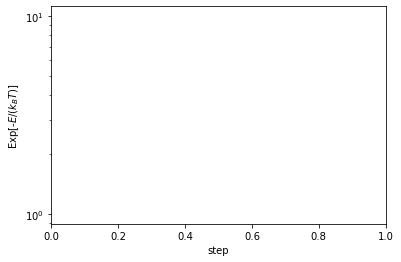

In [169]:
for j in range(n_trajs):
    ps = np.asarray(traj_ens[j]['plist'])
    qs = np.asarray(traj_ens[j]['qlist'])
    
    # plot here
    
    plt.yscale('log')
    plt.xlabel('step')
    plt.ylabel('Exp[-$E / (k_B T)$]')

## Time reversibility

To verify time reversibility let's select the negative of the final momenta and the final positions of the previously sampled trajectories as initial conditions and perform molecular dynamics. 

In [ ]:
inv_traj_ens = {}

for j in range(n_trajs):

    p = -traj_ens[j]['plist'][-1]
    q = traj_ens[j]['qlist'][-1]
    
    inv_traj_ens[j] = {}

    plist = []
    qlist = []
    flist = []
    
    for i in range(steps):

        p = p + (f(q)) * dt / 2
        q = q + p * dt
        p = p + (f(q)) * dt / 2

        plist.append(p)
        qlist.append(q)
        flist.append(f(q))


    inv_traj_ens[j]['plist'] = plist
    inv_traj_ens[j]['qlist'] = qlist
    inv_traj_ens[j]['flist'] = flist
    

<p style="color:blue; font-weight:bold"> To visualize time reversibility can you simultaneously plot the trajectory and the reverse of one initialized using the negative final momentum and the final position? Which of these properties suggest that ring polymer molecular dynamics could be used to approximate the Kubo-transformed TCF </p>

In [ ]:
plt.plot(traj_ens[j]['qlist'])
plt.plot(inv_traj_ens[j]['qlist'][::-1], ls='--')

# EXERCISE 3: Quantum dynamics applied to realistic systems

## The vibrational spectrum of a molecule of H$_{2}$O

In this exercise we will study a simple system that most of you must have been familiar with in your day-to-day lives -- a water molecule. You all may have also heard that there are three types of chracteristic collective motion in a molecule of water: symmetric and asymmetric stretching and a bending mode. Let us calculate the vibrational spectrum of water and check the efficiency of path-integral methods for its estimation.

We will first go to the appropriate folder, create a separate working directory, copy the input_template.xml file and and edit it. You will need to open a terminal and execute

```
$ cd pimd-mooc/3-rpmd
$ mkdir T-300K
$ cd T-300K
$ mkdir P.001
$ cd P.001
$ cp ../../template_trpmd.xml input.xml
```

Set the number of beads `nbeads` to 1 and the temperature to 300 K. These settings will correspond to a standard classical molec ular dyanmics run with a weak thermostat and will give us the classical vibrational density of states. To run this simulation

```
$ i-pi input.xml > log.i-pi &
$ sleep 10
$ i-pi-driver -u -h h2o-molecule -m qtip4pf & 
```

In the meantime, create directories 

```
P.002 P.004 P.008 P.016 P.032 P.064 P.128
```

Copy the input.xml file from the root directory of exercise 3 to the inidividual directories and set the number of beads to 2, 4, 8, 16, 32, 64 and 128, and the temperature to 300 K, in the respective dirctories. Run these simulations (and remember to change the address of the UNIX socket ;))

To calculate the vibrational density of states run the following script

```
$ cd P.001
$ i-pi-getacf -ifile simulation.vc.xyz -mlag 1024 -ftpad 3072 -ftwin cosine-hanning -dt "0.25 femtosecond" -oprefix vv
$ cd ..
```

This will create files 

```
vv_acf.data and vv_facf.data
```

with the normalized velocity autocorrelation function and the the vibrational densitiy of states, respectively. Try the same for all the directories and study the convergence of the vibrational density of states with the number of beads.

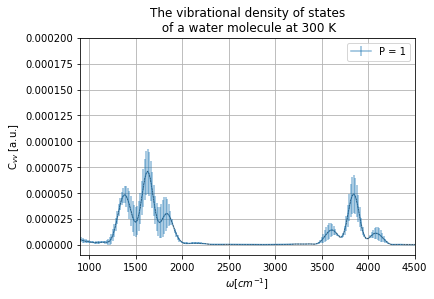

In [177]:
plt.title('The vibrational density of states\n of a water molecule at 300 K')
plt.xlim(900, 4500)
plt.ylim(-0.00001, 0.0002)
plt.xlabel(r'$\omega [cm^{-1}]$')
plt.ylabel(r'C$_{vv}$ [a.u.]')
plt.grid()
P = 1    
w, cvv, cvv_err = np.loadtxt('3-rpmd/T-300K/P.' + str(P).zfill(3) + '/vv_facf.data').T
w = w * 219474 # converts the frequency from atomic units to invcm
plt.plot(w, cvv, alpha =1.0, ls = '--', lw=0.5, c='k')
plt.errorbar(w, cvv, cvv_err, barsabove=True, label='P = ' + str(P), alpha =0.5)
plt.legend(ncol=3)

<p style="color:blue; font-weight:bold"> Can you converge the vibrational density of states of water with respect to the number of replicas? With what P are you able to visibly converge the vibrational spectrum? How is value different for the stretching and bending bands? </p>

In [178]:
# Try here.

Now having studied the covergence for a water molecule, can you also calculate the vibrational density fo states for liquid water at 300 K? Compare the two spectra and try to rationalize the difference in the stretching band. 

Replace ?? with the number of beads that should give a converged spectrum

```
$ mkdir T-300K-bulk
$ cd T-300K
$ mkdir P.0??
$ cd P.0??
$ cp ../../template_trpmd.xml input.xml
```

<p style="color:blue; font-weight:bold"> Can you study the number of beads needed to converge vibrational spectrum of liquid water at 300 K? Is the convergenece behaviour different from the single molecule? Is there change in the vibrational frequencies of the different stretching and bending modes with respect to the single molecule? Can you explain this difference? </p>

In [179]:
# Try here.